In [ ]:
#pip install pandas

In [ ]:
#pip install openpyxl

In [ ]:
#pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
hotels = pd.read_excel('hotels.xlsx')

In [4]:
guests = pd.read_excel('guests.xlsx')

In [5]:
preferences = pd.read_excel('preferences.xlsx')

In [6]:
hotels = hotels.iloc[:, 1:]

In [7]:
preferences = preferences.iloc[:, 1:]

In [8]:
guests.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

In [9]:
hotels[hotels['rooms'] == 0] #just in case

,hotel,rooms,price


In [10]:
hotels_new = pd.DataFrame(columns = ['room_number', 'hotel_number', 'price'])
for i in hotels['hotel']:
    room_numbers = hotels[hotels['hotel'] == i]['rooms'].values[0]
    price = hotels[hotels['hotel'] == i]['price'].values[0]
    a = 0
    for j in range(room_numbers):
        a +=1 
        hotels_new.loc[len(hotels_new)] = [a, i, price]
    hotels_new

In [11]:
random_numbers = np.random.permutation(len(hotels_new))

In [12]:
hotels_new['random_number'] = random_numbers

In [13]:
hotels_new2 = hotels_new[hotels_new['random_number'] <= 3999]

In [14]:
merged_distribution = pd.merge(hotels_new2, guests, left_on = 'random_number', right_on = 'index', how = 'left')

In [26]:
merged_distribution['price_final'] = merged_distribution['price'] * (1 - merged_distribution['discount'])

In [27]:
#result_distribution_group = result_distribution.pivot_table(values='price_final', index='hotel_number', aggfunc='sum')

New price order - my own creation to increase total revenue, still it will increase reputation risks and damage guests' loyalty 

In [29]:
hotels_new_price_order = hotels_new.sort_values(by='price', ascending=False)

In [30]:
hotels_new_price_order = hotels_new_price_order.head(4000)

In [31]:
random_numbers2 = np.random.permutation(len(hotels_new_price_order))

In [32]:
hotels_new_price_order['random_number'] = random_numbers2

In [33]:
merged_distribution_order = pd.merge(hotels_new_price_order, guests, left_on = 'random_number', right_on = 'index', how = 'left')

In [34]:
merged_distribution_order['price_final'] = merged_distribution_order['price'] * (1 - merged_distribution_order['discount'])

In [24]:
#result_distribution_order_group = result_distribution_order.pivot_table(values='price_final', index='hotel_number', aggfunc='sum')

Compare Total Revenues between these two scenarios:

In [35]:
sum(result_distribution_group['price_final']) #first scenario without price ordering

NameError: name 'result_distribution_group' is not defined

In [ ]:
sum(result_distribution_order_group['price_final']) #second scenario with price ordering

Visualisation part

In [36]:
merged_distribution = pd.merge(merged_distribution, hotels, left_on = 'hotel_number', right_on = 'hotel', how = 'left')

In [37]:
merged_distribution.rename(columns={'price_x': 'price'}, inplace=True)

In [38]:
pivot_for_visualisation = merged_distribution.pivot_table(values= ['guest', 'rooms', 'price', 'price_final'], index='hotel', 
                                                          aggfunc={'guest':'count', 'rooms':'mean', 'price':'mean', 'price_final':'sum'})

In [39]:
min(hotels['price']) #min price for defining categories of price

50

In [40]:
max(hotels['price']) #max price for defining categories of price

299

4 categories from 50 to 300 (for beauty numbers) means that we divide categories for 250/4 = 62,5 buckets:
50 - 112,5 
112, 5 - 175
175-237,5
237,5 - 300

In [41]:
conditions = [
    (pivot_for_visualisation['price'] >= 50) & (pivot_for_visualisation['price'] < 112.5),
    (pivot_for_visualisation['price'] >= 112.5) & (pivot_for_visualisation['price'] < 175),
    (pivot_for_visualisation['price'] >= 175) & (pivot_for_visualisation['price'] < 237.5),
    (pivot_for_visualisation['price'] >= 237.5)]

In [42]:
categories = ['Economy', 'Affordable', 'Premium', 'Luxury']

In [49]:
# Assign price categories to hotels and order categories according to lowest and highest 
pivot_for_visualisation['price_category'] = np.select(conditions, categories, default='Unknown')
pivot_for_visualisation['price_category'] = pd.Categorical(pivot_for_visualisation['price_category'], categories=categories, ordered=True)

In [98]:
pivot_for_visualisation = pivot_for_visualisation.reset_index()

In [119]:
pivot_for_visualisation['check_in_percentage'] = pivot_for_visualisation['guest'] / pivot_for_visualisation['rooms'] 

In [123]:
len(pivot_for_visualisation[pivot_for_visualisation['check_in_percentage'] > 0.6]) #80

392

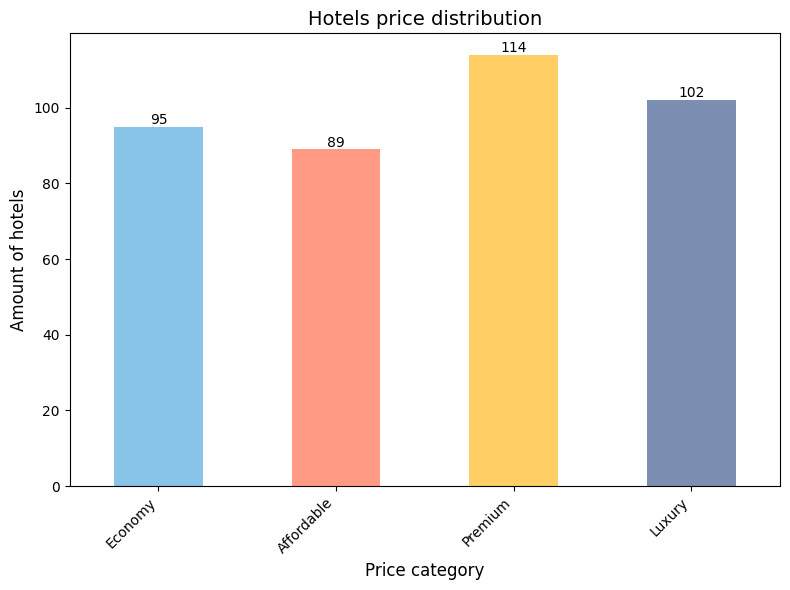

In [65]:
# Count hotels for every category
category_counts = pivot_for_visualisation['price_category'].value_counts().reindex(categories)

# Make graph
plt.figure(figsize=(8, 6))
ax = category_counts.plot(kind='bar', color=['#88c4e8', '#ff9b85', '#ffce64', '#7c8eb1'])  # Столбчатая диаграмма

# Добавляем подписи с цифрами
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',  # Текст (число гостей)
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Позиция (по центру столбика)
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Bar charts settings
plt.title('Hotels price distribution', fontsize=14)
plt.xlabel('Price category', fontsize=12)
plt.ylabel('Amount of hotels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Graph depiction
plt.show()

C:\Users\Mi\AppData\Local\Temp\ipykernel_18596\2808689360.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_guests = pivot_for_visualisation.groupby('price_category')['guest'].sum()


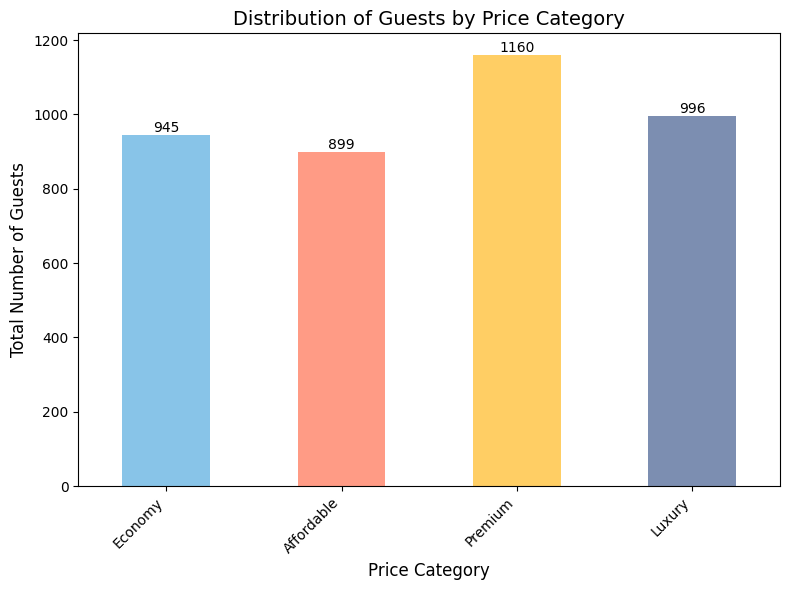

In [61]:
# Группируем данные по ценовой категории и суммируем количество гостей
category_guests = pivot_for_visualisation.groupby('price_category')['guest'].sum()

# Строим график
plt.figure(figsize=(8, 6))  # Устанавливаем размер графика
ax = category_guests.plot(kind='bar', color=['#88c4e8', '#ff9b85', '#ffce64', '#7c8eb1'])  # Столбчатая диаграмма

# Добавляем подписи с цифрами
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',  # Текст (число гостей)
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Позиция (по центру столбика)
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Настройка графика
plt.title('Distribution of Guests by Price Category', fontsize=14)
plt.xlabel('Price Category', fontsize=12)
plt.ylabel('Total Number of Guests', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Улучшает расположение меток

# Показываем график
plt.show()

C:\Users\Mi\AppData\Local\Temp\ipykernel_18596\4250451776.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_revenue = pivot_for_visualisation.groupby('price_category')['price_final'].sum()


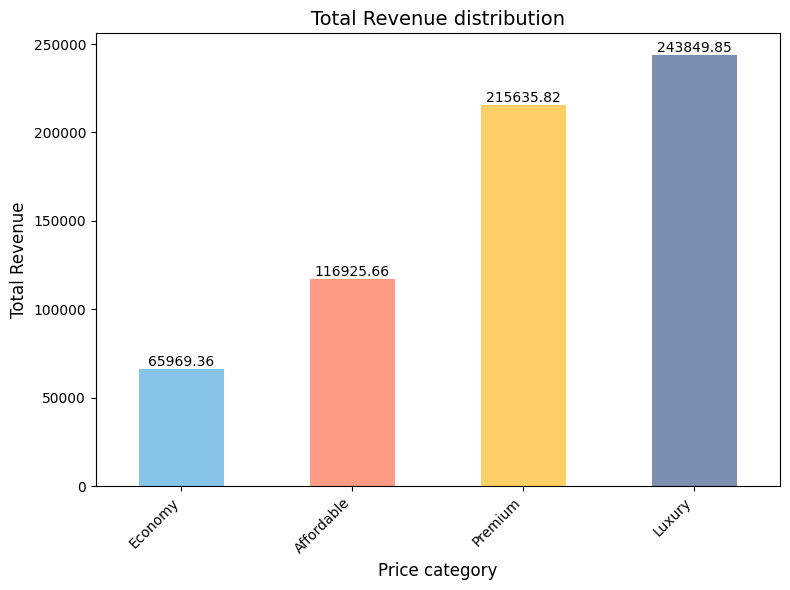

In [66]:
# Группируем данные по категориям и суммируем выручку
category_revenue = pivot_for_visualisation.groupby('price_category')['price_final'].sum()

# Строим график
plt.figure(figsize=(8, 6))  # Устанавливаем размер графика
ax = category_revenue.plot(kind='bar', color=['#88c4e8', '#ff9b85', '#ffce64', '#7c8eb1'])  # Столбчатая диаграмма

# Добавляем подписи с цифрами
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',  # Текст (число гостей)
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Позиция (по центру столбика)
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Настройка графика
plt.title('Total Revenue distribution', fontsize=14)
plt.xlabel('Price category', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот меток оси X
plt.tight_layout()  # Улучшаем расположение элементов графика

# Показываем график
plt.show()

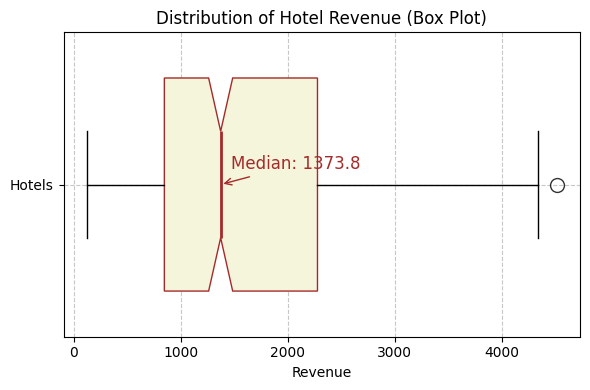

In [90]:
# Строим box plot (ящики с усами)
plt.figure(figsize=(6, 4))
ax = plt.boxplot(pivot_for_visualisation['price_final'], patch_artist=True, notch=True, vert=False, widths=0.7, 
                 medianprops=dict(color='brown', linewidth=2), flierprops=dict(marker='o', color='green', markersize=10, alpha=0.8),
                boxprops=dict(facecolor='beige', color='brown'))

# Настройка графика
plt.title('Distribution of Hotel Revenue (Box Plot)', fontsize=12)
plt.xlabel('Revenue', fontsize=10)
plt.yticks([1], ['Hotels'])
plt.grid(True, linestyle='--', alpha=0.7)

# Аннотируем медиану
median_value = round(pivot_for_visualisation['price_final'].median(), 2)
plt.annotate(f'Median: {median_value}', xy=(median_value, 1), xytext=(median_value + 100, 1.05),
             arrowprops=dict(arrowstyle="->", color='brown'), fontsize=12, color='brown')

# Показываем график
plt.tight_layout()
plt.show()

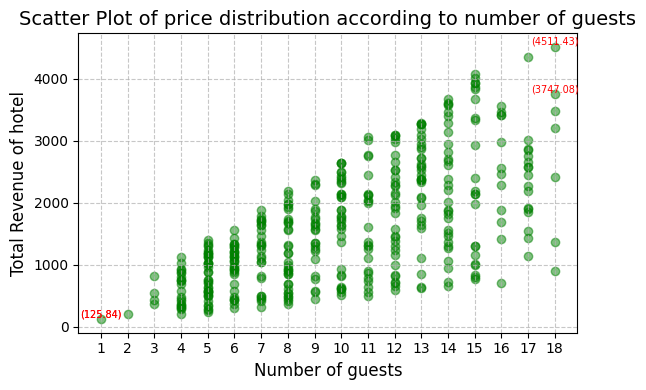

In [117]:
# Извлекаем значения для осей x и y (замените 'x_column' и 'y_column' на реальные имена столбцов)
x = pivot_for_visualisation['guest']  # замените 'x_column' на имя вашего столбца для оси x
y = pivot_for_visualisation['price_final']  # замените 'y_column' на имя вашего столбца для оси y

# Строим диаграмму рассеяния
plt.figure(figsize=(6, 4))
plt.scatter(x, y, alpha=0.5, color='green')

# Настройка оси X, чтобы отображались только целые числа
plt.xticks(range(int(x.min()), int(x.max())+1, 1))  # шаг 1

# Выбираем только несколько ключевых точек для подписей (например, максимальные и минимальные)
key_points_indices = [x.idxmax(), x.idxmin(),y.idxmax(), y.idxmin()]  # Индексы точек с максимальными и минимальными значениями

# Подписываем только ключевые точки
for idx in key_points_indices:
    plt.text(x[idx], y[idx], f'({y[idx]:.2f})', fontsize=7, ha='center', va = 'bottom', color='red')

# Настройка графика
plt.title('Scatter Plot of price distribution according to number of guests', fontsize=14)
plt.xlabel('Number of guests', fontsize=12)  # Замените на нужную метку оси x
plt.ylabel('Total Revenue of hotel', fontsize=12)  # Замените на нужную метку оси y
plt.grid(True, linestyle='--', alpha=0.7)

# Показываем график
plt.tight_layout()
plt.show()

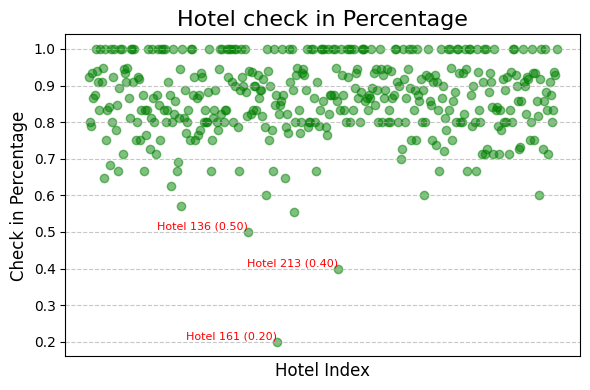

In [129]:
# Столбцы, которые вас интересуют:
x = pivot_for_visualisation.index  # Индекс отелей (используем индексы вместо названий)
y = pivot_for_visualisation['check_in_percentage']  # Процент заселения

# Строим диаграмму рассеяния
plt.figure(figsize=(6, 4))
plt.scatter(x, y, alpha=0.5, color='green')

# Найдем индексы 3 самых незаселённых отелей
bottom_3_hotels = pivot_for_visualisation.nsmallest(3, 'check_in_percentage')

# Добавляем подписи для этих отелей
for idx in bottom_3_hotels.index:
    plt.text(idx, bottom_3_hotels.loc[idx, 'check_in_percentage'], 
             f'Hotel {idx} ({bottom_3_hotels.loc[idx, "check_in_percentage"]:.2f})', 
             fontsize=8, ha='right', va='bottom', color='red')

# Настройка графика
plt.title('Hotel check in Percentage', fontsize=16)
plt.xlabel('Hotel Index', fontsize=12)  # Название оси X
plt.ylabel('Check in Percentage', fontsize=12)

# Отключаем метки на оси X, так как их слишком много
plt.xticks([])  # Отключаем метки

# Настройка сетки
plt.grid(True, linestyle='--', alpha=0.7)

# Показываем график
plt.tight_layout()
plt.show()

In [ ]:
#visualisation
1) hotels - total revenue distribution (5-10 buckets) (simple graph without categories) +
2) hotels - percentage of checking in (understand: with categories or not) +
3) hotel price and its revenue (4 categories of hotel price and sum of revenue) +
4) hotel price and distribution of guests according to categories (amount of guests) +
5) guests - priorities score (?) difficult (if hotel is in top 5 priorities - just number?) 


Part 2

In [35]:
start_df = preferences[preferences['priority'] == 1]

In [36]:
start_df['rn'] = start_df.groupby('hotel').cumcount() + 1

C:\Users\Mi\AppData\Local\Temp\ipykernel_14908\3157429541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['rn'] = start_df.groupby('hotel').cumcount() + 1


In [37]:
df_hotels = pd.merge(start_df, hotels, on = 'hotel', how = 'left')

In [38]:
df_full = pd.merge(df_hotels, guests, on = 'guest', how = 'left')

In [39]:
guests_first_priority = df_full[df_full['rn'] <= df_full['rooms']]

In [40]:
guests_second_priority = df_full[df_full['rn'] > df_full['rooms']]

In [41]:
guests_first_priority[guests_first_priority['hotel'] == 'hotel_1'] #just check everything is alright

,guest,hotel,priority,rn,rooms,price,index,discount
170,guest_171,hotel_1,1,1,13,273,170,0.19
305,guest_306,hotel_1,1,2,13,273,305,0.03
455,guest_456,hotel_1,1,3,13,273,455,0.12
599,guest_600,hotel_1,1,4,13,273,599,0.17
1359,guest_1360,hotel_1,1,5,13,273,1359,0.04
1391,guest_1392,hotel_1,1,6,13,273,1391,0.19
3076,guest_3077,hotel_1,1,7,13,273,3076,0.11
3106,guest_3107,hotel_1,1,8,13,273,3106,0.08
3699,guest_3700,hotel_1,1,9,13,273,3699,0.01
3867,guest_3868,hotel_1,1,10,13,273,3867,0.08


In [42]:
hotels_rest = guests_first_priority.pivot_table(values= ['guest', 'rooms'], index='hotel', aggfunc={'guest':'count', 'rooms':'mean'})

In [43]:
hotels_rest['rooms'] = hotels_rest['rooms'].astype(int) #можно не делать в принципе

In [44]:
hotels_rest['rest'] = hotels_rest['rooms'] - hotels_rest['guest']

Снова идем по вторым приоритетам для оставшихся 602 гостей с учетом заселенных номеров

In [45]:
guests_second_priority = pd.merge(guests_second_priority, preferences.query('priority == 2'), on = 'guest', how = 'left')

In [46]:
guests_second_priority = pd.merge(guests_second_priority, hotels_rest, left_on = 'hotel_y', right_on = 'hotel', how = 'left')

In [47]:
guests_second_priority['rn_2'] = guests_second_priority.groupby('hotel_y').cumcount() + 1

In [48]:
guests_third_priority = guests_second_priority[guests_second_priority['rn_2'] > guests_second_priority['rest']] #осталось расселить еще 281 гостя

In [49]:
guests_second_priority = guests_second_priority[guests_second_priority['rn_2'] <= guests_second_priority['rest']] #расселены еще 308 гостей

Делаем цикл, потому что непонятно сколько еще таких шагов предстоит пройти

In [50]:
list_priorities= preferences['priority'].unique().tolist()

In [51]:
checked_in_guests = pd.DataFrame()
hotels_rest = hotels
not_checked_in_guests = guests

In [52]:
start_df = preferences[(preferences['priority'] == 1) & preferences['guest'].isin(not_checked_in_guests['guest']) ]

,guest,hotel,priority
0,guest_1,hotel_168,1
18,guest_2,hotel_369,1
60,guest_3,hotel_157,1
86,guest_4,hotel_235,1
132,guest_5,hotel_121,1
...,...,...,...
99380,guest_3996,hotel_350,1
99424,guest_3997,hotel_19,1
99452,guest_3998,hotel_160,1
99489,guest_3999,hotel_277,1


In [53]:
start_df['rn'] = start_df.groupby('hotel').cumcount() + 1

C:\Users\Mi\AppData\Local\Temp\ipykernel_14908\3157429541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['rn'] = start_df.groupby('hotel').cumcount() + 1


In [54]:
df_hotels = pd.merge(start_df, hotels_rest, on = 'hotel', how = 'left')
df_hotels

,guest,hotel,priority,rn,rooms,price
0,guest_1,hotel_168,1,1,13,298
1,guest_2,hotel_369,1,1,6,133
2,guest_3,hotel_157,1,1,6,65
3,guest_4,hotel_235,1,1,5,136
4,guest_5,hotel_121,1,1,15,56
...,...,...,...,...,...,...
3995,guest_3996,hotel_350,1,10,12,56
3996,guest_3997,hotel_19,1,4,10,113
3997,guest_3998,hotel_160,1,14,11,68
3998,guest_3999,hotel_277,1,15,18,281


In [55]:
checked_in_guests = pd.concat([checked_in_guests, df_hotels[df_hotels['rn'] <= df_hotels['rooms']]], ignore_index=True)
checked_in_guests

,guest,hotel,priority,rn,rooms,price
0,guest_1,hotel_168,1,1,13,298
1,guest_2,hotel_369,1,1,6,133
2,guest_3,hotel_157,1,1,6,65
3,guest_4,hotel_235,1,1,5,136
4,guest_5,hotel_121,1,1,15,56
...,...,...,...,...,...,...
3393,guest_3993,hotel_359,1,8,14,163
3394,guest_3994,hotel_58,1,10,15,120
3395,guest_3996,hotel_350,1,10,12,56
3396,guest_3997,hotel_19,1,4,10,113


In [56]:
hotels_rest = checked_in_guests.pivot_table(values= ['guest', 'rooms', 'price'], index='hotel', aggfunc={'guest':'count', 'rooms':'mean', 'price':'mean'})

In [57]:
hotels_rest = hotels_rest.reset_index()

In [58]:
hotels_rest['rest'] = hotels_rest['rooms'] - hotels_rest['guest']

In [59]:
hotels_rest = hotels_rest.rename(columns={'guest': 'guests'})

In [60]:
checked_in_guests[checked_in_guests['rn'] == 2]

,guest,hotel,priority,rn,rooms,price
10,guest_11,hotel_157,1,2,6,65
17,guest_18,hotel_215,1,2,9,133
38,guest_39,hotel_121,1,2,15,56
84,guest_85,hotel_266,1,2,18,169
85,guest_86,hotel_277,1,2,18,281
...,...,...,...,...,...,...
2627,guest_2830,hotel_19,1,2,10,113
2727,guest_2968,hotel_13,1,2,15,198
2792,guest_3058,hotel_286,1,2,8,207
2808,guest_3083,hotel_334,1,2,7,83


In [61]:
checked_in_guests = pd.DataFrame()
hotels_rest = hotels
hotels_rest['rest'] = hotels['rooms']
hotels_rest['guests'] = 0
not_checked_in_guests = guests
while not not_checked_in_guests.empty:
    for priority in list_priorities:
        start_df = preferences[(preferences['priority'] == priority) & preferences['guest'].isin(not_checked_in_guests['guest']) ]
        start_df['rn'] = start_df.groupby('hotel').cumcount() + 1
        df_hotels = pd.merge(start_df, hotels_rest, on = 'hotel', how = 'left')
        checked_in_guests = pd.concat([checked_in_guests, df_hotels[df_hotels['rn'] <= df_hotels['rest']]], ignore_index=True)
        not_checked_in_guests = df_hotels[df_hotels['rn'] > df_hotels['rest']]
        
        hotels_rest = checked_in_guests.pivot_table(values= ['guest', 'rooms', 'price'], index='hotel', aggfunc={'guest':'count', 'rooms':'mean', 'price':'mean'})
        hotels_rest = hotels_rest.rename(columns={'guest': 'guests'})
        hotels_rest['rest'] = hotels_rest['rooms'] - hotels_rest['guests']
        hotels_rest = hotels_rest.reset_index()
        print(priority, len(checked_in_guests))

C:\Users\Mi\AppData\Local\Temp\ipykernel_14908\1903805619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['rn'] = start_df.groupby('hotel').cumcount() + 1
C:\Users\Mi\AppData\Local\Temp\ipykernel_14908\1903805619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['rn'] = start_df.groupby('hotel').cumcount() + 1
C:\Users\Mi\AppData\Local\Temp\ipykernel_14908\1903805619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

1 3398
2 3706
3 3828
4 3890
5 3924
6 3941
7 3952
8 3959
9 3964


C:\Users\Mi\AppData\Local\Temp\ipykernel_14908\1903805619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['rn'] = start_df.groupby('hotel').cumcount() + 1
C:\Users\Mi\AppData\Local\Temp\ipykernel_14908\1903805619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['rn'] = start_df.groupby('hotel').cumcount() + 1
C:\Users\Mi\AppData\Local\Temp\ipykernel_14908\1903805619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

10 3966
11 3967
12 3971
13 3971
14 3971
15 3972
16 3972
17 3972
18 3972
19 3972
20 3972
21 3972
22 3972
23 3972
24 3972
25 3972
26 3972
27 3972
28 3972
29 3972
30 3972
31 3972
32 3972
33 3972
34 3972
35 3972
36 3972
37 3972
38 3972
39 3972
40 3972
41 3972
42 3972
43 3972
44 3972
45 3972
46 3972
47 3972
48 3972
49 3972


In [62]:
check_df = preferences[~preferences['guest'].isin(checked_in_guests['guest'])] #these guests will be distributed according to the cheapest hotels

In [63]:
guests_leftovers = check_df['guest'].unique().tolist()

In [64]:
x = len(guests_leftovers)

In [65]:
hotels_for_leftovers = hotels_rest[hotels_rest['rest'] > 0].sort_values('price') #additional marketing step to let leftovers check in in the cheapest hotels

In [66]:
rooms_leftovers = pd.merge(hotels_new, hotels_for_leftovers, left_on = 'hotel_number', right_on = 'hotel', how = 'inner')

In [67]:
rooms_leftovers = rooms_leftovers[rooms_leftovers['room_number'] > rooms_leftovers['guests']]

In [68]:
rooms_leftovers = rooms_leftovers.sort_values('price_x')[:x]

In [69]:
rooms_leftovers['guest'] = guests_leftovers

In [70]:
rooms_leftovers['priority'] = 0

In [71]:
rooms_leftovers = rooms_leftovers.rename(columns={'price_y': 'price'})

In [72]:
checked_in_guests = checked_in_guests[['guest', 'hotel', 'priority', 'price', 'rooms']]

In [73]:
rooms_leftovers = rooms_leftovers[['guest', 'hotel', 'priority', 'price', 'rooms']]

In [74]:
final_guests = pd.concat([checked_in_guests, rooms_leftovers], ignore_index=True)

In [75]:
final_guests = pd.merge(final_guests, guests, on = 'guest', how = 'left')

In [76]:
final_guests['price_final'] = final_guests['price'] * (1 - final_guests['discount'])

In [77]:
result_distribution_group_part2 = final_guests.pivot_table(values='price_final', index='hotel', aggfunc='sum')

In [81]:
final_guests

,guest,hotel,priority,price,rooms,index,discount,price_final
0,guest_1,hotel_168,1,298.0,13.0,0,0.09,271.18
1,guest_2,hotel_369,1,133.0,6.0,1,0.00,133.00
2,guest_3,hotel_157,1,65.0,6.0,2,0.07,60.45
3,guest_4,hotel_235,1,136.0,5.0,3,0.00,136.00
4,guest_5,hotel_121,1,56.0,15.0,4,0.10,50.40
...,...,...,...,...,...,...,...,...
3995,guest_3770,hotel_26,0,55.0,19.0,3769,0.06,51.70
3996,guest_3789,hotel_167,0,55.0,9.0,3788,0.19,44.55
3997,guest_3795,hotel_26,0,55.0,19.0,3794,0.18,45.10
3998,guest_3943,hotel_26,0,55.0,19.0,3942,0.13,47.85


In [79]:
sum(result_distribution_group_part2['price_final'])

644159.43

Part 3

In [ ]:
1. Заселяем сначала все самые дешевые отели - сортируем таблицу с комнатами hotels_new по цене
2. Для каждого отеля по порядку: получить список гостей исходя из порядка и приоритета

создать датасет для каждого отеля - временный 
создать совокупный датасет

для каждого отеля отобрать только тех гостей, у которых он встречается в приоритетах
hotel - guest - priority - *rn

отсортировать по приоритету, затем по гостю 
пронумеровать и оставить только тех, кто меньше количества комнат 

также сделать датасеты с заселенными и незаселенными гостями, чтобы в новой итерации обращаться к измененному списку гостей 
то есть датасет с гостями будет меняться

In [110]:
priorities = []
for i in range(1, max(preferences['priority']) + 1):
    priorities.append(i)

In [111]:
hotels_new = hotels_new.sort_values(by = ['price', 'hotel_number', 'room_number'])

In [112]:
hotels = hotels.sort_values('price')

In [113]:
hotels_draft = hotels.copy()
df_draft = pd.DataFrame()
dict_hotels = hotels_draft.groupby('price')['hotel'].apply(list).to_dict()
checked_in_full = pd.DataFrame(columns = ['guest'])
for key in dict_hotels:
    for hotel in dict_hotels[key]:
        df_draft_0 = preferences[(preferences['hotel'] == hotel) & ~preferences['guest'].isin(checked_in_full['guest'])] #исключаем тех, кого заселили
        df_draft = pd.concat([df_draft, df_draft_0], ignore_index=True)
    for priority in priorities:
        df_priority = df_draft[(df_draft['priority'] == priority) & ~df_draft['guest'].isin(checked_in_full['guest'])] #исключить тех, кого заселили
        for hotel in dict_hotels[key]:
            checked_in_guests = df_priority[df_priority['hotel'] == hotel]
            free_rooms = hotels_draft[hotels_draft['hotel'] == hotel]['rooms'].values[0]
            checked_in_guests = checked_in_guests[:free_rooms]
            checked_in_full = pd.concat([checked_in_full, checked_in_guests], ignore_index=True)
            hotels_draft.loc[hotels_draft['hotel'] == hotel, 'rooms'] -= len(checked_in_guests)
    print(key, dict_hotels[key], len(checked_in_full), 'done')       
    df_draft = pd.DataFrame()

50 ['hotel_49', 'hotel_190'] 29 done
52 ['hotel_301', 'hotel_354'] 47 done
53 ['hotel_24'] 56 done
54 ['hotel_365', 'hotel_47', 'hotel_23', 'hotel_321'] 115 done
55 ['hotel_167', 'hotel_26'] 143 done
56 ['hotel_121', 'hotel_320', 'hotel_350', 'hotel_53', 'hotel_15'] 203 done
57 ['hotel_249', 'hotel_242'] 232 done
58 ['hotel_6'] 242 done
59 ['hotel_92', 'hotel_144'] 267 done
60 ['hotel_247'] 281 done
61 ['hotel_22'] 298 done
64 ['hotel_252'] 311 done
65 ['hotel_157', 'hotel_155'] 324 done
66 ['hotel_135', 'hotel_120', 'hotel_273'] 360 done
67 ['hotel_109'] 371 done
68 ['hotel_397', 'hotel_160', 'hotel_262'] 409 done
69 ['hotel_7', 'hotel_134'] 430 done
71 ['hotel_283'] 439 done
72 ['hotel_174'] 452 done
73 ['hotel_268', 'hotel_102', 'hotel_104', 'hotel_279', 'hotel_189'] 515 done
74 ['hotel_305', 'hotel_339'] 543 done
75 ['hotel_360', 'hotel_79', 'hotel_88', 'hotel_337'] 582 done
76 ['hotel_295', 'hotel_224'] 614 done
77 ['hotel_77'] 626 done
78 ['hotel_280'] 638 done
79 ['hotel_177', '

In [114]:
#check
check = checked_in_full.pivot_table(values= ['guest'], index='hotel', aggfunc={'guest':'count'})
check = check.reset_index()
check = pd.merge(check, hotels, on = 'hotel', how = 'left')
len(check[check['guest'] != check['rooms']]) #53 hotels are not full - too expensive

53

In [116]:
leftovers_expensive = preferences[~preferences['guest'].isin(checked_in_full['guest'])]['guest'].unique() #3990 - 10 guests without hotel - why?

In [117]:
len(leftovers_expensive)

10

In [ ]:
#Check 10 guests and check in them in expensive hotels

In [118]:
df_for_leftovers_expensive = pd.merge(hotels_new, check[check['guest'] != check['rooms']], left_on = 'hotel_number', right_on = 'hotel', how = 'inner')

In [119]:
df_for_leftovers_expensive = df_for_leftovers_expensive[df_for_leftovers_expensive['room_number'] <= df_for_leftovers_expensive['guest']]

In [120]:
df_for_leftovers_expensive = df_for_leftovers_expensive.sort_values('price_y')

In [121]:
df_for_leftovers_expensive = df_for_leftovers_expensive[:len(leftovers_expensive)]

In [122]:
df_for_leftovers_expensive['leftovers'] = leftovers_expensive

In [123]:
df_for_leftovers_expensive = df_for_leftovers_expensive[['leftovers', 'hotel']]

In [124]:
df_for_leftovers_expensive['priority'] = 0

In [125]:
df_for_leftovers_expensive = df_for_leftovers_expensive.rename(columns={'leftovers': 'guest'})

In [126]:
checked_in_full_final = pd.concat([checked_in_full, df_for_leftovers_expensive])

In [127]:
checked_in_full_final = pd.merge(checked_in_full_final, guests, on = 'guest', how = 'left')

In [128]:
checked_in_full_final = pd.merge(checked_in_full_final, hotels, on = 'hotel', how = 'left')

In [129]:
checked_in_full_final['price_final'] = checked_in_full_final['price'] * (1 - checked_in_full_final['discount'])

In [130]:
checked_in_group_part3 = checked_in_full_final.pivot_table(values='price_final', index='hotel', aggfunc='sum')

In [131]:
checked_in_group_part3

,price_final
hotel,
hotel_1,1231.23
hotel_10,2026.86
hotel_100,2734.40
hotel_101,2136.16
hotel_102,1015.43
...,...
hotel_95,237.33
hotel_96,2340.00
hotel_97,757.44


In [132]:
sum(checked_in_group_part3['price_final'])

581017.41

Part 4

In [ ]:
#sorted by availability starting with the most roomy hotel 

In [133]:
priorities = []
for i in range(1, max(preferences['priority']) + 1):
    priorities.append(i)

In [134]:
hotels = hotels.sort_values('rooms', ascending=False)

In [142]:
hotels_draft = hotels.copy()
df_draft = pd.DataFrame()
dict_hotels = hotels_draft.groupby('rooms')['hotel'].apply(list).to_dict()
checked_in_full = pd.DataFrame(columns = ['guest'])
for key in sorted(dict_hotels, reverse=True):
    for hotel in dict_hotels[key]:
        df_draft_0 = preferences[(preferences['hotel'] == hotel) & ~preferences['guest'].isin(checked_in_full['guest'])] #исключаем тех, кого заселили
        df_draft = pd.concat([df_draft, df_draft_0], ignore_index=True)
    for priority in priorities:
        df_priority = df_draft[(df_draft['priority'] == priority) & ~df_draft['guest'].isin(checked_in_full['guest'])] #исключить тех, кого заселили
        for hotel in dict_hotels[key]:
            checked_in_guests = df_priority[df_priority['hotel'] == hotel]
            free_rooms = hotels_draft[hotels_draft['hotel'] == hotel]['rooms'].values[0]
            checked_in_guests = checked_in_guests[:free_rooms]
            checked_in_full = pd.concat([checked_in_full, checked_in_guests], ignore_index=True)
            hotels_draft.loc[hotels_draft['hotel'] == hotel, 'rooms'] -= len(checked_in_guests)
    print(key, dict_hotels[key], len(checked_in_full), 'done')       
    df_draft = pd.DataFrame()

19 ['hotel_129', 'hotel_276', 'hotel_115', 'hotel_11', 'hotel_52', 'hotel_394', 'hotel_29', 'hotel_53', 'hotel_26', 'hotel_49', 'hotel_100', 'hotel_303', 'hotel_366', 'hotel_114', 'hotel_378', 'hotel_346', 'hotel_317', 'hotel_122'] 342 done
18 ['hotel_56', 'hotel_392', 'hotel_144', 'hotel_277', 'hotel_278', 'hotel_2', 'hotel_344', 'hotel_173', 'hotel_12', 'hotel_39', 'hotel_305', 'hotel_189', 'hotel_32', 'hotel_356', 'hotel_372', 'hotel_142', 'hotel_126', 'hotel_17', 'hotel_374', 'hotel_313', 'hotel_59', 'hotel_264', 'hotel_4', 'hotel_328', 'hotel_323', 'hotel_266'] 810 done
17 ['hotel_251', 'hotel_143', 'hotel_380', 'hotel_282', 'hotel_331', 'hotel_222', 'hotel_90', 'hotel_191', 'hotel_237', 'hotel_46', 'hotel_284', 'hotel_245', 'hotel_22', 'hotel_388', 'hotel_308', 'hotel_75', 'hotel_25', 'hotel_105', 'hotel_165', 'hotel_316', 'hotel_200', 'hotel_223', 'hotel_110', 'hotel_183', 'hotel_205', 'hotel_309'] 1252 done
16 ['hotel_249', 'hotel_399', 'hotel_194', 'hotel_285', 'hotel_94', 'ho

In [143]:
#check
check = checked_in_full.pivot_table(values= ['guest'], index='hotel', aggfunc={'guest':'count'})
check = check.reset_index()
check = pd.merge(check, hotels, on = 'hotel', how = 'left')
len(check[check['guest'] != check['rooms']]) #53 hotels are not full - too expensive

73

In [147]:
check2 = checked_in_full.pivot_table( index='guest',  aggfunc={'guest':'count'})

In [148]:
check2[check2['guest'] == 1] #3990 so cool!

,guest
guest,
guest_1,1
guest_10,1
guest_100,1
guest_1000,1
guest_1001,1
...,...
guest_995,1
guest_996,1
guest_997,1


In [150]:
think_tank = ['hotel_190', 'hotel_49']
df_for_hotel = pd.DataFrame()
df_merged = pd.DataFrame()
not_checked_in_guests = preferences
for hotel in think_tank:
    df_for_hotel = not_checked_in_guests[not_checked_in_guests['hotel'] == hotel]
    df_for_hotel = df_for_hotel.sort_values(by = ['priority']).sort_index(ascending=True)
    df_for_hotel.to_excel(f'output_{hotel}.xlsx', index=False)

In [151]:
pivot_hotels = hotels.pivot_table(values='hotel', index='price', aggfunc='count')

Все, что дальше - не нужно